**USING LANGGRAPH**





In [45]:
from dotenv import load_dotenv

load_dotenv()

True

In [72]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter

import glob
import os

embedding_function = OpenAIEmbeddings()
db_name = "vector_db"


folders = glob.glob("knowledge-base/*")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

text_loader_kwargs = {'encoding': 'utf-8'}


documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")



# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embedding_function).delete_collection()

# Creating vectorstore

db  = Chroma.from_documents(documents=chunks, embedding=embedding_function, persist_directory=db_name)
print(f"Vectorstore created with {db._collection.count()} documents")



Created a chunk of size 1493, which is longer than the specified 1000
Created a chunk of size 1031, which is longer than the specified 1000
Created a chunk of size 1255, which is longer than the specified 1000
Created a chunk of size 1277, which is longer than the specified 1000
Created a chunk of size 1160, which is longer than the specified 1000


Total number of chunks: 79
Document types found: {'local-transport-and-rentals', 'travel-packages-and-itineraries', 'hotel-information', 'travel-insurance', 'flight-information', 'safety-and-emergency-information', 'visa-and-travel-documentation', 'currency-exchange-and-budgeting'}
Vectorstore created with 79 documents


In [47]:
collection = db._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 79 vectors with 1,536 dimensions in the vector store


In [71]:
retriever = db.as_retriever(search_kwargs={"k": 6})

In [59]:
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration:

Chathistory: {history}

Context: {context}

Question: {question}

and also remember You're a fun, chatty, and engaging travel assistant! Answer the question in a polite, humorous, and conversational way while keeping it short and informative. Encourage follow-up chats! Use humor and friendly language where appropriate.

"""
prompt = ChatPromptTemplate.from_template(template)

In [60]:
llm = ChatOpenAI(model="gpt-4o-mini")
rag_chain = prompt | llm

In [74]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END


class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage


class GradeQuestion(BaseModel):
    score: float = Field(description="Confidence score that the question is about the specified topics. Ranges from 0.0 to 1.0.")


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                # content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
                content="You are a friendly, witty, and engaging travel assistant who loves chatting with users! You rephrase questions in a natural, conversational way while keeping them informative and useful."

            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = ChatOpenAI(model="gpt-4o-mini")
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state


def question_classifier(state: AgentState):
    print("Entering question_classifier")

    system_message = SystemMessage(
        content="""You are a classifier that determines whether a user's question is about one of the following topics:

        1. Flight Information, including booking policies, baggage rules, cancellations, refunds, rescheduling, no-show & missed flight policies, and travel class upgrades.
        2. Hotel Information, including booking guidelines, cancellations, deposits, extra charges, peak season pricing, and refund policies.
        3. Visa and Travel Documentation, including visa requirements, application processes, rejection reasons, and necessary travel documents.
        4. Travel Packages and Itineraries, including package details, popular destinations, sample itineraries, pricing, inclusions, and insurance recommendations.
        5. Local Transport and Rentals, including airport transfers, public transport, car rentals, and ride-sharing options.
        6. Travel Insurance, including types of coverage, exclusions, and claims processes.
        7. Safety and Emergency Information, including emergency contacts, common travel scams, health advisories, and safety tips.
        8. Currency Exchange and Budgeting, including exchange options, rate tracking, ATM withdrawals, budgeting, and money safety tips.
        
        Provide a confidence score from 0.0 to 1.0. A higher score means higher confidence that the question is on one of these topics."""
    )
    

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    confidence_score = state.get("on_topic", 0.0)

    if confidence_score >= 0.5:
        print(f"Routing to retrieve with Confidence Score: {confidence_score}")
        return "retrieve"
    else:
        print(f"Routing to off_topic_response with Confidence Score: {confidence_score}")
        return "off_topic_response"


def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state


class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )


def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state


def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"


def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o-mini")
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state


import random

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_question}
    )

    response_text = response.content.strip()

    # Fun, engaging follow-up lines
    fun_replies = [
        "Hope that helps! Need more travel tips? 😊",
        "That’s the scoop! Got any other questions? ✈️",
        "Wanna know more? Just ask! 🌍",
        "If you’re curious about anything else, I’m all ears! 👂",
        "Travel talk is my jam! Hit me up with another question. 🚀"
    ]

    # Add a random fun reply to the response
    generation = f"{response_text} {random.choice(fun_replies)}"

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state






def cannot_answer(state: AgentState):
    print("Entering cannot_answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(
        AIMessage(
            content="I'm sorry, but I cannot find the information you're looking for."
        )
    )
    return state


def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="Oof, I wish I could help with that! But I’m all about travel. Wanna ask me about flights, hotels, or dreamy destinations instead? 😎✈️"))
    return state

In [75]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [63]:
# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)

workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)
workflow.add_edge("retrieve", "retrieval_grader")
workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",
    },
)
workflow.add_edge("refine_question", "retrieve")
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)
workflow.set_entry_point("question_rewriter")
graph = workflow.compile(checkpointer=checkpointer)

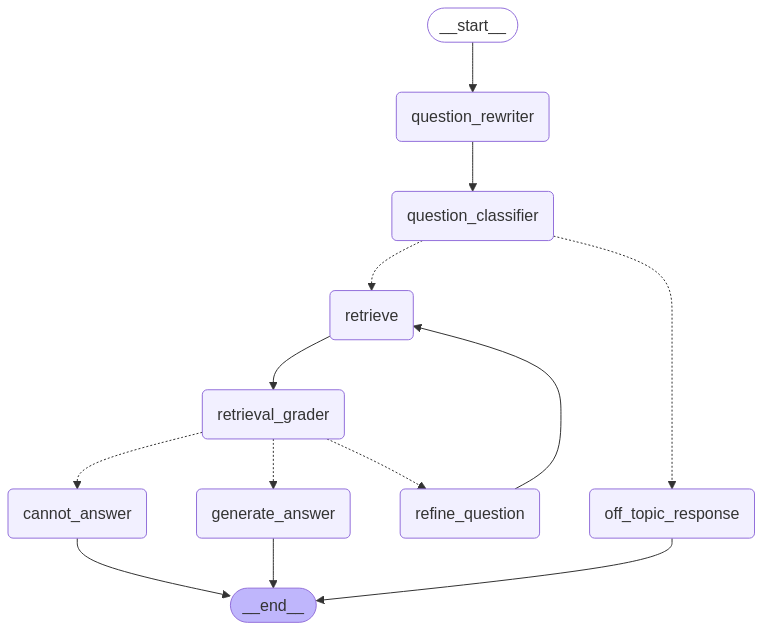

In [64]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [65]:
input_data = {
    "question": HumanMessage(content="what are the popular destinations to visit?")
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'question': HumanMessage(content='what are the popular destinations to visit?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = 0.9
Entering on_topic_router
Routing to retrieve with Confidence Score: 0.9
Entering retrieve
retrieve: Retrieved 6 documents
Entering retrieval_grader
Grading document: ---
### **4.2 Popular_Destinat... Result: Yes
Grading document: ---

#### **4. Africa**

- **C... Result: Yes
Grading document: ---

#### **Sample Daily Budge... Result: Yes
Grading document: ---
### **7.3 Common_Travel_Sc... Result: No
Grading document: ---
### **4.3 Sample_Itinerari... Result: Yes
Grading document: ---
### **4.1 Travel_Package_O... Result: No
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: Oh, absolutely! Packing your bags for an adventure? Let me sprinkle some

{'messages': [HumanMessage(content='what are the popular destinations to visit?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Oh, absolutely! Packing your bags for an adventure? Let me sprinkle some destination magic on your plans! 🌍✨ Here are some popular spots that definitely deserve a visit:\n\n### **1. Europe:**\n- **Paris, France:** What’s a trip without a selfie at the Eiffel Tower? Oh la la!\n- **Rome, Italy:** History, gelato, and the Colosseum – it\'s a trifecta!\n- **Amsterdam, Netherlands:** Canals, museums, and those cute little bicycles!\n\n### **2. Asia:**\n- **Bali, Indonesia:** Sun, surf, and maybe some monkey business!\n- **Tokyo, Japan:** Neon lights and sushi that\'ll make you say "Wow!"\n- **Maldives:** Picture-perfect beaches and luxurious relaxation – yes, please!\n\n### **3. North America:**\n- **New York City, USA:** Because who doesn’t want to feel like a movie star in Times Square?\n- **Los Angeles, USA:** Hollywood dreams and Disneyland 

In [66]:
input_data = {"question": HumanMessage(content="in that suggest me one?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='what are the popular destinations to visit?', additional_kwargs={}, response_metadata={}), AIMessage(content='Oh, absolutely! Packing your bags for an adventure? Let me sprinkle some destination magic on your plans! 🌍✨ Here are some popular spots that definitely deserve a visit:\n\n### **1. Europe:**\n- **Paris, France:** What’s a trip without a selfie at the Eiffel Tower? Oh la la!\n- **Rome, Italy:** History, gelato, and the Colosseum – it\'s a trifecta!\n- **Amsterdam, Netherlands:** Canals, museums, and those cute little bicycles!\n\n### **2. Asia:**\n- **Bali, Indonesia:** Sun, surf, and maybe some monkey business!\n- **Tokyo, Japan:** Neon lights and sushi that\'ll make you say "Wow!"\n- **Maldives:** Picture-perfect beaches and luxurious relaxation – yes, please!\n\n### **3. North America:**\n- **New York City, USA:** Because who doesn’t want to feel like a movie star in Times Square?\n- **Los A

{'messages': [HumanMessage(content='what are the popular destinations to visit?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Oh, absolutely! Packing your bags for an adventure? Let me sprinkle some destination magic on your plans! 🌍✨ Here are some popular spots that definitely deserve a visit:\n\n### **1. Europe:**\n- **Paris, France:** What’s a trip without a selfie at the Eiffel Tower? Oh la la!\n- **Rome, Italy:** History, gelato, and the Colosseum – it\'s a trifecta!\n- **Amsterdam, Netherlands:** Canals, museums, and those cute little bicycles!\n\n### **2. Asia:**\n- **Bali, Indonesia:** Sun, surf, and maybe some monkey business!\n- **Tokyo, Japan:** Neon lights and sushi that\'ll make you say "Wow!"\n- **Maldives:** Picture-perfect beaches and luxurious relaxation – yes, please!\n\n### **3. North America:**\n- **New York City, USA:** Because who doesn’t want to feel like a movie star in Times Square?\n- **Los Angeles, USA:** Hollywood dreams and Disneyland 

In [73]:

import re

user_name = None

def extract_name(question):

    patterns = [
        r"\bmy name is (\w+)\b",
        r"\bi am (\w+)\b",
        r"\bthis is (\w+)\b",
        r"\bcall me (\w+)\b",
        r"\bi'm (\w+)\b",
        r"\bthey call me (\w+)\b",
        r"\bthe name's (\w+)\b",
        r"\bname me (\w+)\b",
        r"\bjust call me (\w+)\b",
        r"\bpeople call me (\w+)\b",
        r"\byou can call me (\w+)\b",
        r"\bhello, (\w+)\b",
        r"\bhey, (\w+)\b",
        r"\bhi, i'm (\w+)\b",
        r"\bit's (\w+)\b",
        r"\bmy friends call me (\w+)\b",
        r"\bknown as (\w+)\b"
    ]

    for pattern in patterns:
        match = re.search(pattern, question, re.IGNORECASE)
        if match:
            return match.group(1)

    return None





def process_question(question: str, thread_id: int = 1):
    global user_name
    
    # Check for greetings
    if any(greet in question.lower() for greet in ["hi", "hello", "hey"]):
        if user_name:
            return f"Hey {user_name}! Welcome back! What’s on your travel wishlist today? 🌍✈️"
        return "Hey there! What should I call you? 😊"
    
    # Check if user introduced themselves
    name = extract_name(question)
    if name:
        user_name = name
        return f"Nice to meet you, {user_name}! Ask me anything about travel. 🌍✈️"

    input_data = {"question": HumanMessage(content=question)}
    result = graph.invoke(input=input_data, config={"configurable": {"thread_id": thread_id}})
    
    messages = result.get("messages", [])
    ai_responses = [msg.content for msg in messages if isinstance(msg, AIMessage)]
    
    return ai_responses[-1] if ai_responses else "Sorry, I couldn't find an answer."


In [70]:

import gradio as gr

def gradio_interface(question):
    """
    Gradio chat interface function to process user questions.
    """
    return process_question(question)

# Create Gradio Chat UI
with gr.Blocks(theme=gr.themes.Soft()) as ui:
    gr.Markdown("# ✈️ Travel Assistant")
    gr.Markdown("Ask me anything about flights, hotels, visas, travel packages, and more!")

    chatbot = gr.Chatbot(label="Travel Assistant", type="messages")
    msg = gr.Textbox(placeholder="Type your question here...", label="Your Question")

    def chat_function(messages, message):
        response = gradio_interface(message)
        messages.append({"role": "user", "content": message})
        messages.append({"role": "assistant", "content": response})
        return messages, ""

    msg.submit(chat_function, [chatbot, msg], [chatbot, msg])

# Launch UI
ui.launch()


* Running on local URL:  http://127.0.0.1:7896

To create a public link, set `share=True` in `launch()`.


Entering question_rewriter with following state: {'messages': [HumanMessage(content='what are the popular destinations to visit?', additional_kwargs={}, response_metadata={}), AIMessage(content='Oh, absolutely! Packing your bags for an adventure? Let me sprinkle some destination magic on your plans! 🌍✨ Here are some popular spots that definitely deserve a visit:\n\n### **1. Europe:**\n- **Paris, France:** What’s a trip without a selfie at the Eiffel Tower? Oh la la!\n- **Rome, Italy:** History, gelato, and the Colosseum – it\'s a trifecta!\n- **Amsterdam, Netherlands:** Canals, museums, and those cute little bicycles!\n\n### **2. Asia:**\n- **Bali, Indonesia:** Sun, surf, and maybe some monkey business!\n- **Tokyo, Japan:** Neon lights and sushi that\'ll make you say "Wow!"\n- **Maldives:** Picture-perfect beaches and luxurious relaxation – yes, please!\n\n### **3. North America:**\n- **New York City, USA:** Because who doesn’t want to feel like a movie star in Times Square?\n- **Los A